# <center> AI / ML Project - Pima Indian Diabetes Detection 
#### <center> ***Domain: Healthcare***

### Description:
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. <br><br>The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. Can you build a machine learning model to accurately predict whether or not the patients in the dataset have diabetes or not?

# <center>1. Data Exploration

In [2]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [3]:
#Importing the dataset

df = pd.read_csv('datasets/Diabetes.csv')

target = 'Outcome'
labels = ['Non-Diabetic','Datiabetic']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Inference: The Datset consists of 9 features & 768 samples.


In [4]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Outcome                       2
Pregnancies                  17
BloodPressure                47
SkinThickness                51
Age                          52
Glucose                     136
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
dtype: int64

In [6]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 8 numerical & 0 categorical features.


In [7]:
#Checking the stats of all the columns

display(df.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Inference:** The stats seem to be fine, let us gain more undestanding by visualising the dataset.

---

# <center> 2. Exploratory Data Analysis (EDA)

            Target Variable Distribution           


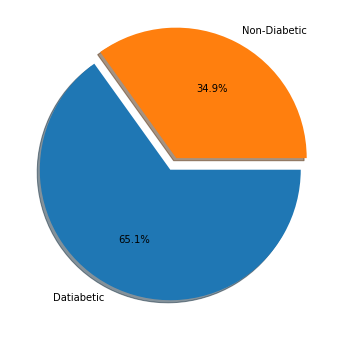

In [8]:
#Let us first analyze the distribution of the target variable

MAP={}
for e, i in enumerate(df[target].unique()):
    MAP[i]=labels[e]
df1 = df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

**Inference:** The Target Variable seems to be slightly imbalanced! Hence we shall try to perform data augmentation.

**Inference:** Visualizing the categorical features reveal lot of information about the dataset.

                                     Features Distribution                                      


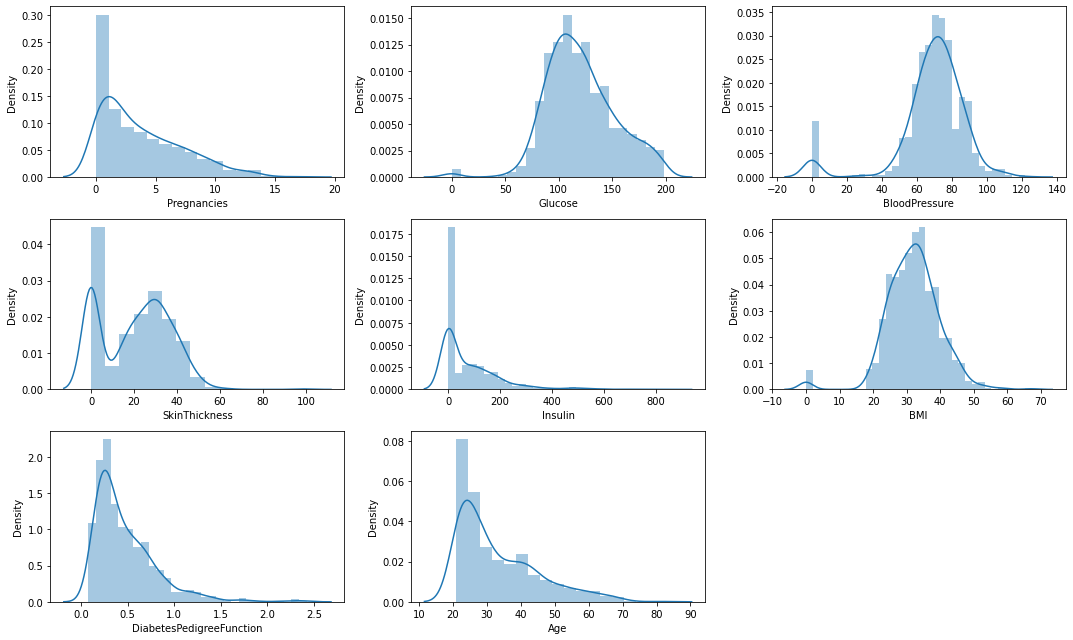

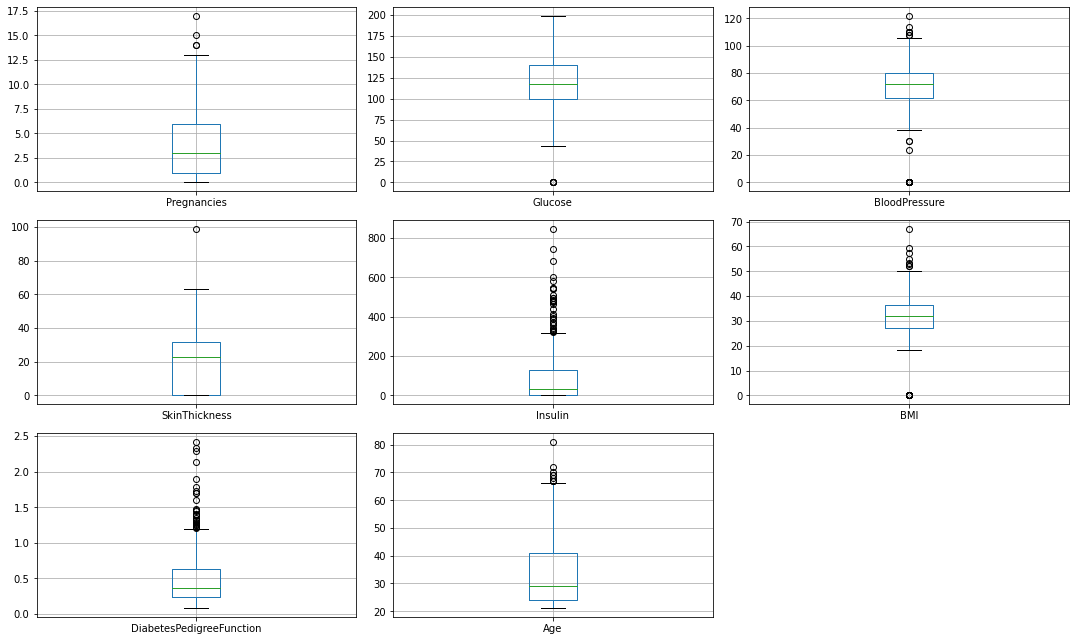

In [10]:
#Understanding the feature set

print('\033[1mFeatures Distribution'.center(100))

nf = [i for i in features if i not in cf]

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    sns.distplot(df[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(features)/3)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(features)/3),3,c+1)
    df.boxplot(nf[c])
plt.tight_layout()
plt.show()

**Inference:** The data is somewhat normally distributed. And there are many outliers present in the dataset. We shall fix these outliers..

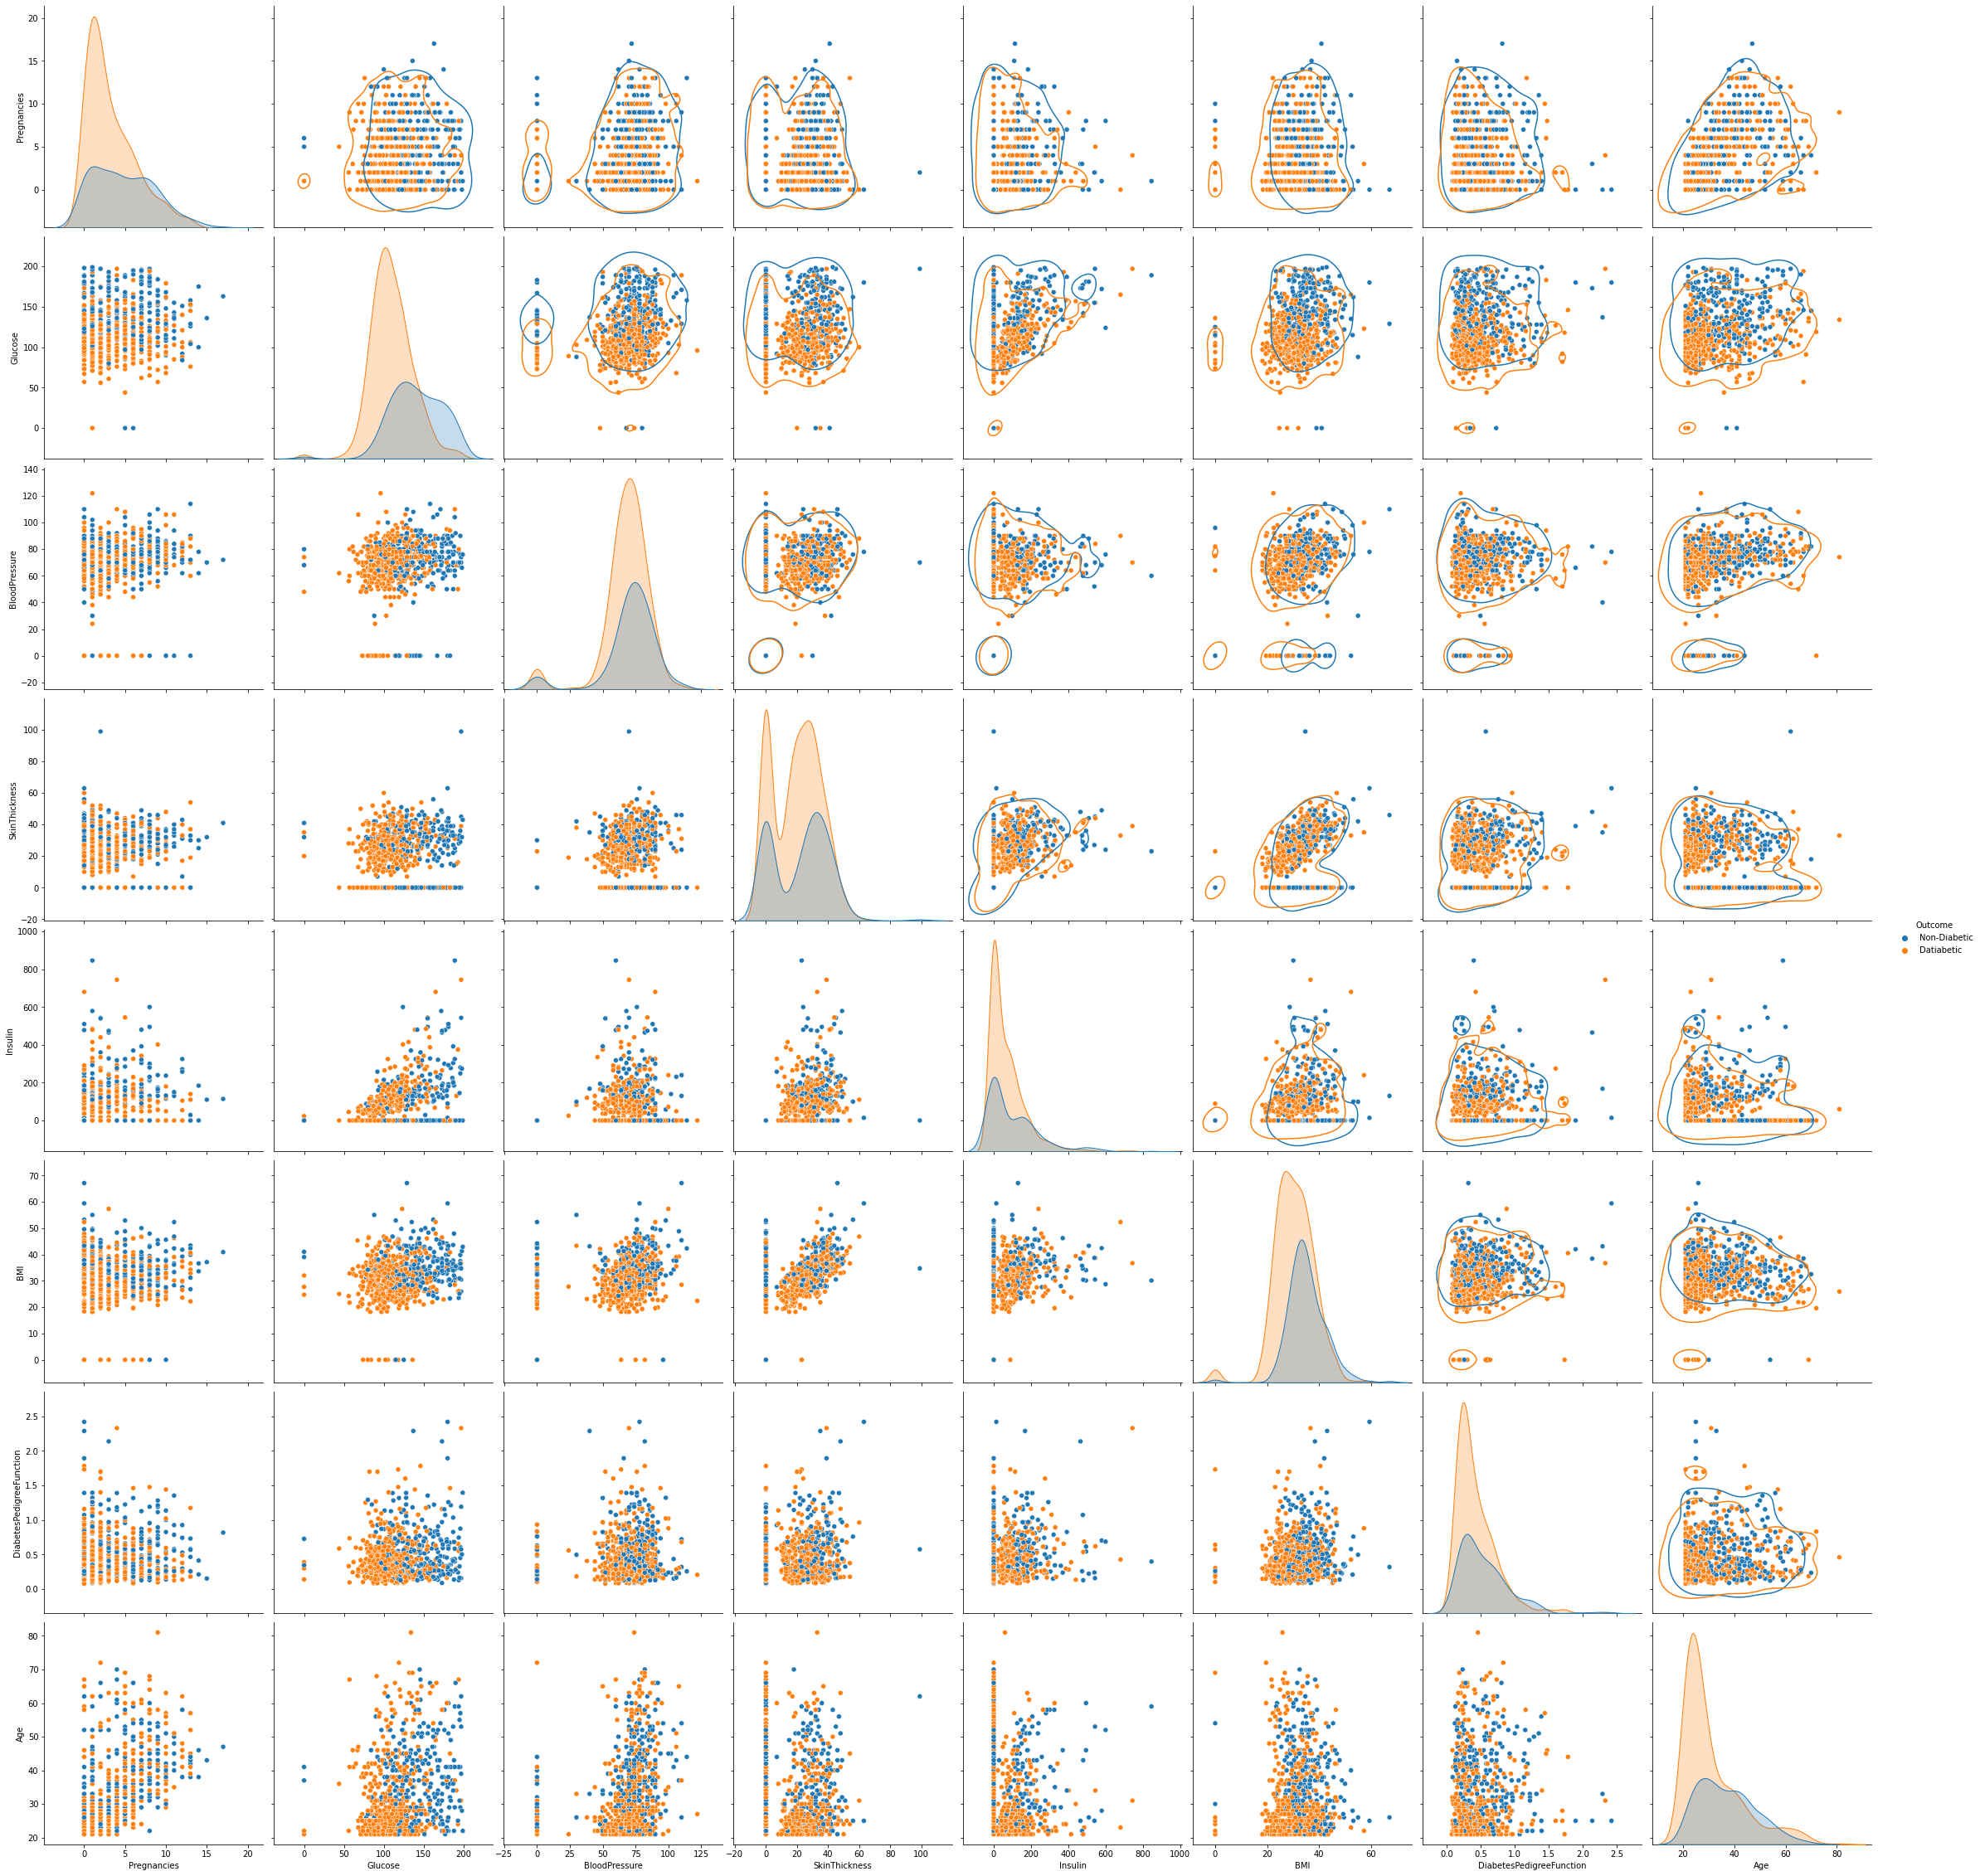

In [11]:
#Understanding the relationship between all the features

g=sns.pairplot(df1, hue=target, size=4)
g.map_upper(sns.kdeplot, levels=1, color=".2")
plt.show()

**Inference:** The data samples of most of the features do show some patterns. Also they seem
to have lot of overlap for the outcome classes, making it difficult to be distingusihable. 
Let is proceed to perform cleanup on the data to remove the irregularities...

---

# <center> 3. Data Preprocessing

In [12]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [13]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

                          Total Null Values  Percentage
Pregnancies                               0         0.0
Glucose                                   0         0.0
BloodPressure                             0         0.0
SkinThickness                             0         0.0
Insulin                                   0         0.0
BMI                                       0         0.0
DiabetesPedigreeFunction                  0         0.0
Age                                       0         0.0
Outcome                                   0         0.0


**Inference:** There are many outliers in the dataset. Let us try to impute the missing values

In [14]:
#Converting categorical Columns to Numeric

ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

In [17]:
#Removal of outlier:

df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.25)
        Q3 = df4[i].quantile(0.75)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,5,116,74,0,0,25.6,0.201,30,0



Inference: Before removal of outliers, The dataset had 768 samples.
Inference: After removal of outliers, The dataset now has 636 samples.


In [18]:
#Fixing the imbalance using SMOTE Technique

df5 = df4.copy()

print('Original class distribution:')
print(df5[target].value_counts())

xf = df5.columns
X = df5.drop([target],axis=1)
Y = df5[target]

smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

df5 = pd.DataFrame(X, columns=xf)
df5[target] = Y

print('\nClass distribution after applying SMOTE Technique:',)
print(Y.value_counts())

Original class distribution:
0    439
1    197
Name: Outcome, dtype: int64

Class distribution after applying SMOTE Technique:
1    439
0    439
Name: Outcome, dtype: int64


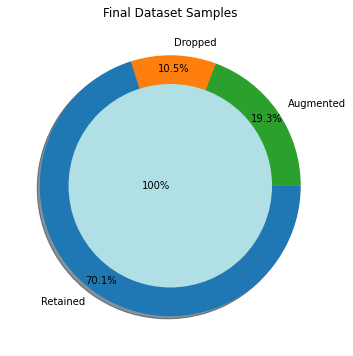


Inference:The final dataset after cleanup has 878 samples & 9 columns.


In [19]:
#Final Dataset size after performing Preprocessing

df = df5.copy()
plt.title('Final Dataset Samples')
plt.pie([df.shape[0], original_df.shape[0]-df4.shape[0], df5.shape[0]-df4.shape[0]], radius = 1, shadow=True,
        labels=['Retained','Dropped','Augmented'], counterclock=False, autopct='%1.1f%%', pctdistance=0.9, explode=[0,0,0])
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78, shadow=True, colors=['powderblue'])
plt.show()

print('\n\033[1mInference:\033[0mThe final dataset after cleanup has {} samples & {} columns.'.format(df.shape[0], df.shape[1]))

---

# <center> 4. Data Manipulation

In [20]:
#Splitting the data intro training & testing sets

df = df5.copy()

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (878, 8) (878,) 
Training set  --->  (702, 8) (702,) 
Testing set   --->  (176, 8)  (176,)


In [21]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,7.020000e+02,7.020000e+02,7.020000e+02,7.020000e+02,7.020000e+02,7.020000e+02,7.020000e+02,7.020000e+02
mean,-1.101525e-16,-7.077276e-17,2.691737e-16,1.897817e-17,-4.554761e-17,1.157668e-16,1.122875e-16,3.757678e-16
std,1.000713e+00,1.000713e+00,1.000713e+00,1.000713e+00,1.000713e+00,1.000713e+00,1.000713e+00,1.000713e+00
min,-1.266289e+00,-2.697978e+00,-3.211089e+00,-1.358706e+00,-8.418240e-01,-2.373047e+00,-1.507786e+00,-1.217789e+00
25%,-9.541627e-01,-7.408039e-01,-7.198697e-01,-1.358706e+00,-8.418240e-01,-6.686658e-01,-7.756383e-01,-8.368228e-01
50%,-1.778495e-02,-1.437000e-01,-7.399793e-02,2.536606e-01,-3.486200e-01,1.308661e-02,-2.294671e-01,-2.653738e-01
75%,6.064669e-01,6.856110e-01,6.641412e-01,7.696178e-01,6.632986e-01,6.461424e-01,6.309397e-01,6.870413e-01
max,2.791348e+00,2.410578e+00,3.063094e+00,2.510973e+00,2.877048e+00,2.723864e+00,3.096727e+00,2.972838e+00



                                Standardardization on Testing set                                


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,-0.044387,-0.016665,-0.102307,-0.062950,-0.022974,-0.113774,0.059531,-0.125217
std,0.993696,1.059410,0.950500,0.946576,0.939729,0.935726,1.013880,0.921936
min,-1.266289,-2.134046,-2.657485,-1.358706,-0.841824,-2.015938,-1.537713,-1.217789
25%,-0.954163,-0.773976,-0.812137,-1.358706,-0.841824,-0.820789,-0.760675,-0.836823
50%,-0.329911,-0.243217,-0.073998,0.060177,-0.212564,-0.157580,-0.118309,-0.360615
75%,0.606467,0.859766,0.571874,0.705123,0.598105,0.457433,0.729237,0.496558
max,2.791348,2.344233,2.694024,1.995016,2.899724,2.447917,3.083901,2.782355


---

# <center> 5. Feature Selection/Extraction

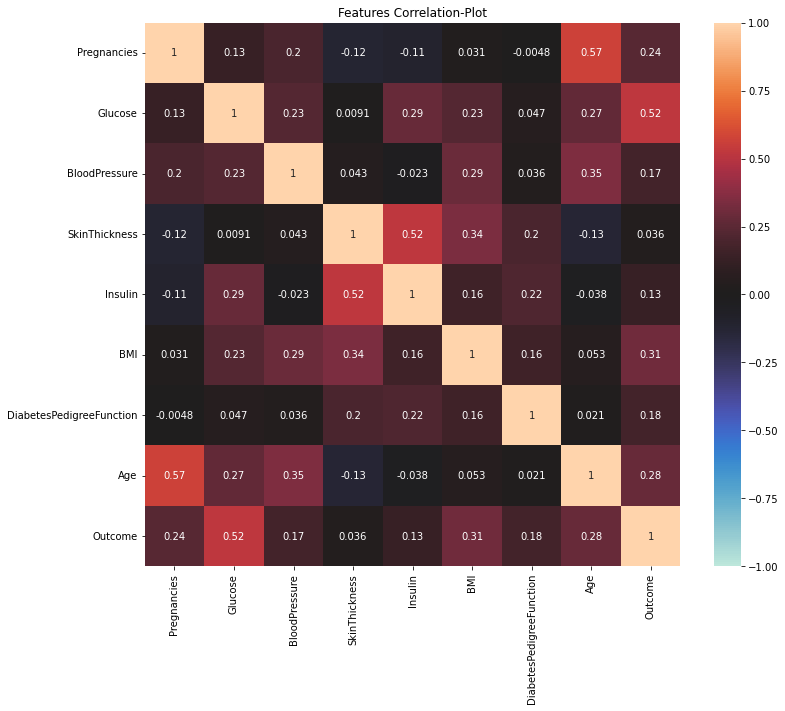

In [22]:
#Checking the correlation

features = df.columns
plt.figure(figsize=[12,10])
plt.title('Features Correlation-Plot')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0, annot=True) #, 
plt.show()

**Inference:** \
Correlation plt between the variables convey lot of information about the realationship betweem them. There seems to be strong multicollinearity in the dataset.

Let us check with different techniques if we can improve the model's performance by performing Feature Selection/Extraction steps to take care of these multi-collinearity...

**Strategy:** \
We can fix these multicollinearity with two techniques:
1. Manual Method - Variance Inflation Factor (VIF)
2. Automatic Method - Recursive Feature Elimination (RFE)
3. Decomposition Method - Principle Component Analysis (PCA)

## 5a. Manual Method - VIF

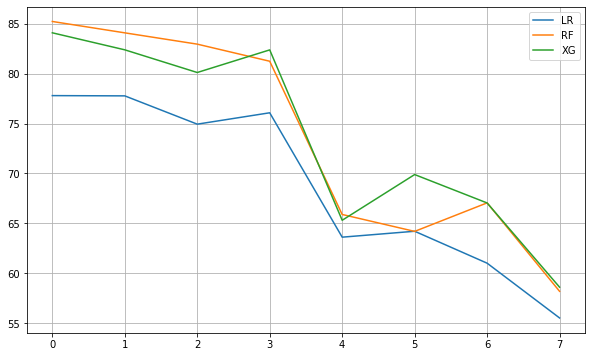

In [23]:
# Calculate the VIFs to remove multicollinearity

DROP=[]; scores1=[]; scores2=[]; scores3=[]
scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y, eval_metric='logloss').predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        
for i in range(len(X.columns.values)-1):
    vif = pd.DataFrame()
    Xs = X.drop(DROP,axis=1)
    vif['Features'] = Xs.columns
    vif['VIF'] = [variance_inflation_factor(Xs.values, i) for i in range(Xs.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    DROP.append(vif.Features[0])
    if vif.VIF[0]>1:
        scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y, eval_metric='logloss').predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
plt.legend()
plt.grid()
plt.show()

## 5b. Automatic Method - RFE

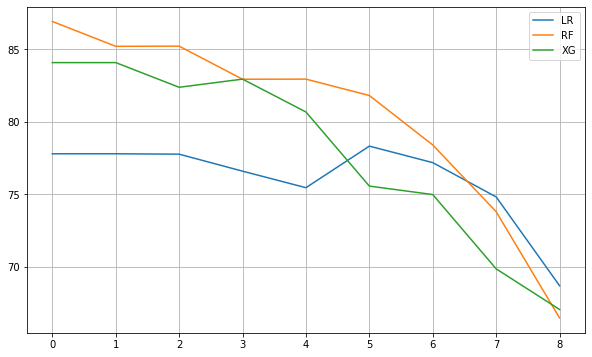

In [24]:
# Applying Recurrsive Feature Elimination

# Running RFE with the output number of the variable equal to 10
LR = LogisticRegression()
scores1=[]; scores2=[]; scores3=[]
scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std, Train_Y, eval_metric='logloss').predict(Test_X_std),average='weighted')*100)

for i in range(len(X.columns.values)):
    rfe = RFE(LR,n_features_to_select=len(Train_X_std.columns)-i)   
    rfe = rfe.fit(Train_X_std, Train_Y)
    scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y, eval_metric='logloss').predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
plt.legend()
plt.grid()
plt.show()

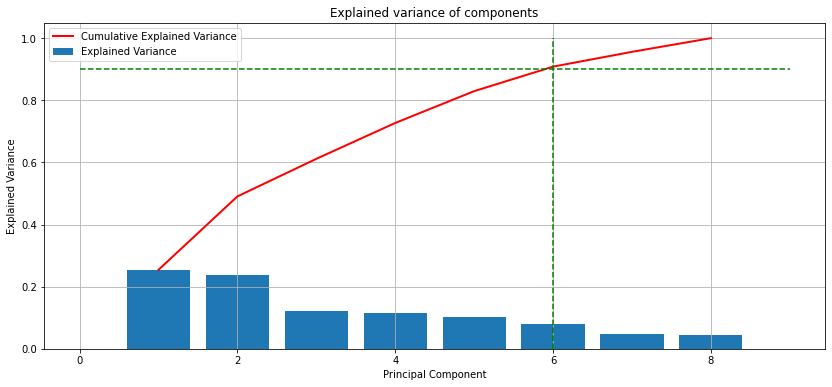

In [25]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(14,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.90,0.90],'g--')
plt.plot([6,6],[0,1], 'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.grid()
plt.legend()
plt.show()

**Inference:** We shall avoid performing dimensionality reduction for the current problem.

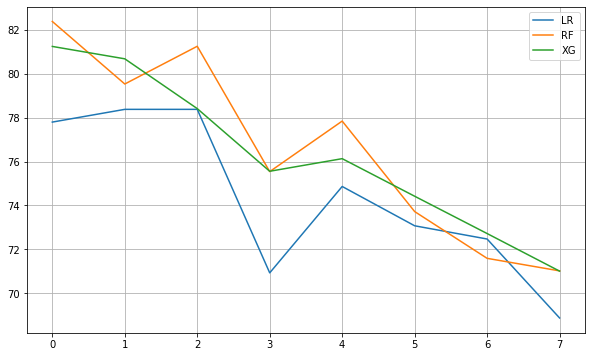

In [26]:
#Applying PCA Transformations

scores1=[]; scores2=[]; scores3=[]
for i in range(len(X.columns.values)):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca)

    Test_X_std_pca = pca.transform(Test_X_std)
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    
    scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std_pca, Train_Y).predict(Test_X_std_pca),average='weighted')*100)
    scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std_pca, Train_Y).predict(Test_X_std_pca),average='weighted')*100)
    scores3.append(f1_score(Test_Y,XGBClassifier().fit(Train_X_std_pca, Train_Y, eval_metric='logloss').predict(Test_X_std_pca),average='weighted')*100)

    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')
plt.plot(scores3, label='XG')
plt.legend()
plt.grid()
plt.show()

**Inference:** In VIF, RFE & PCA Techniques, we did notice any better scores upon dropping some multicollinear features. But in order to avoid the curse of dimensionality, we can capture top 90% of the data Variance explained by top n PCA components.

In [27]:
#### Finalising the shortlisted features

rfe = RFE(LR,n_features_to_select=len(Train_X_std.columns))   
rfe = rfe.fit(Train_X_std, Train_Y)

print(f1_score(Test_Y,LogisticRegression().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
print(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
print(f1_score(Test_Y,XGBClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y, eval_metric='logloss').predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    
Train_X_std = Train_X_std[Train_X_std.columns[rfe.support_]]
Test_X_std = Test_X_std[Test_X_std.columns[rfe.support_]]

print(Train_X_std.shape)
print(Test_X_std.shape)

77.79572305021406
84.65760472291618
84.0909090909091
(702, 8)
(176, 8)


---

# <center> 6. Predictive Modeling

In [28]:
#Let us create first create a table to store the results of various models 

Evaluation_Results = pd.DataFrame(np.zeros((8,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)',
                         'Support Vector Machine (SVM)','K Nearest Neighbours (KNN)', 'Gradient Boosting (GB)','Extreme Gradient Boosting (XGB)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0
Support Vector Machine (SVM),0.0,0.0,0.0,0.0,0.0
K Nearest Neighbours (KNN),0.0,0.0,0.0,0.0,0.0
Gradient Boosting (GB),0.0,0.0,0.0,0.0,0.0
Extreme Gradient Boosting (XGB),0.0,0.0,0.0,0.0,0.0


In [29]:
#Let us define functions to summarise the Prediction's scores .

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob[:,1], multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #
    print('\n\033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

---

## 1. Logistic Regression:

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 77.8%
F1 Score = 77.8%

Confusiton Matrix:
 [[73 16]
 [23 64]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79        89
           1       0.80      0.74      0.77        87

    accuracy                           0.78       176
   macro avg       0.78      0.78      0.78       176
weighted avg       0.78      0.78      0.78       176



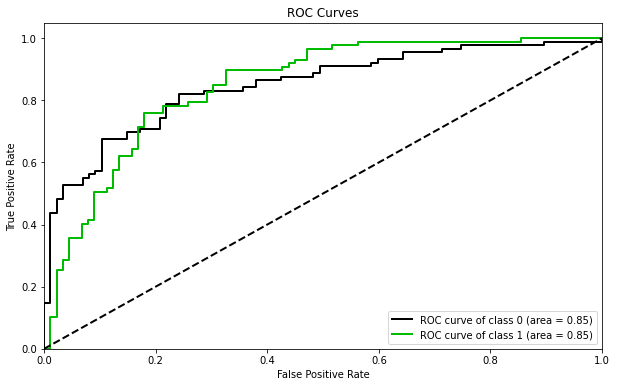


Interpreting the Output of Logistic Regression:

intercept  0.04762592675471795
classes [0 1]


,coeff
Pregnancies,0.305001
Glucose,1.395649
BloodPressure,-0.218535
SkinThickness,-0.134144
Insulin,-0.065253
BMI,0.716549
DiabetesPedigreeFunction,0.460595
Age,0.290882


In [30]:
# Building Logistic Regression Classifier

LR_model = LogisticRegression()

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(LR_model, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

LR = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = LR.predict(Test_X_std)
pred_prob = LR.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,0)

print('\n\033[1mInterpreting the Output of Logistic Regression:\n\033[0m')

print('intercept ', LR.intercept_[0])
print('classes', LR.classes_)
display(pd.DataFrame({'coeff': LR.coef_[0]}, index=Train_X_std.columns))

---

## 2. Decisoin Tree Classfier:

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 74.4%
F1 Score = 74.4%

Confusiton Matrix:
 [[62 27]
 [18 69]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.70      0.73        89
           1       0.72      0.79      0.75        87

    accuracy                           0.74       176
   macro avg       0.75      0.74      0.74       176
weighted avg       0.75      0.74      0.74       176



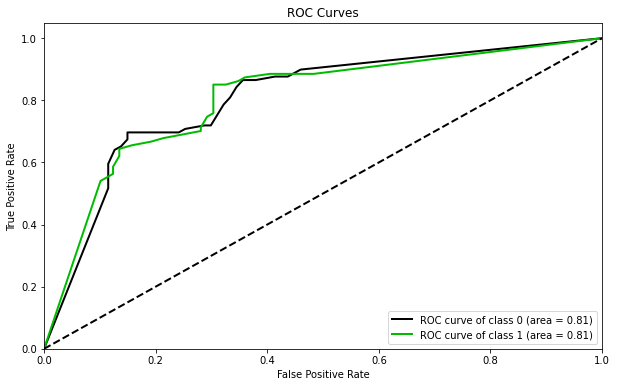


Interpreting the output of Decision Tree:



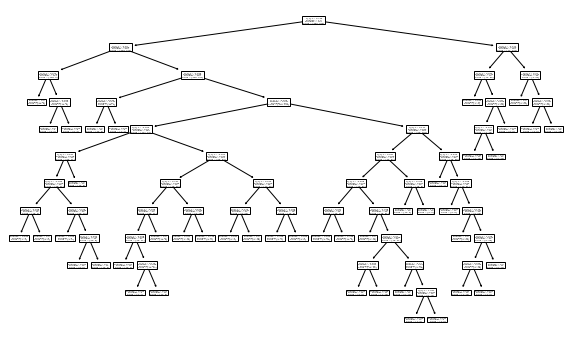

In [31]:
#Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(DT_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

DT = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = DT.predict(Test_X_std)
pred_prob = DT.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,1)

print('\n\033[1mInterpreting the output of Decision Tree:\n\033[0m')
tree.plot_tree(DT)
plt.show()

---

## 3. Random Forest Classfier:

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 85.8%
F1 Score = 85.8%

Confusiton Matrix:
 [[77 12]
 [13 74]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86        89
           1       0.86      0.85      0.86        87

    accuracy                           0.86       176
   macro avg       0.86      0.86      0.86       176
weighted avg       0.86      0.86      0.86       176



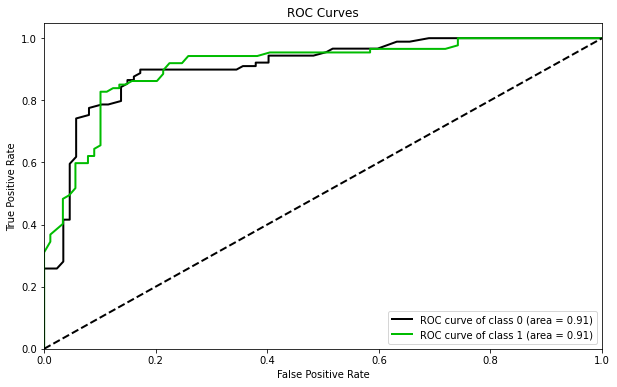


Interpreting the output of Random Forest:



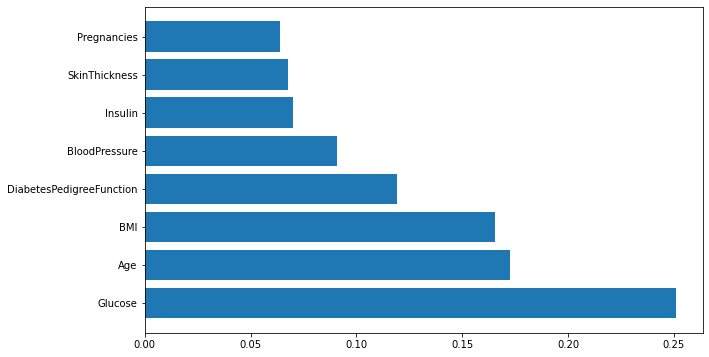

In [32]:
# Building Random-Forest Classifier

RF_model = RandomForestClassifier()

param_dist={'bootstrap': [True, False],
            'max_depth': [10, 20, 50, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [50, 100]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(RF_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

RF = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = RF.predict(Test_X_std)
pred_prob = RF.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,2)

print('\n\033[1mInterpreting the output of Random Forest:\n\033[0m')
rfi=pd.Series(RF.feature_importances_, index=Train_X_std.columns).sort_values(ascending=False)
plt.barh(rfi.index,rfi.values)
plt.show()

---

## 4. Naive Bayes Classfier:

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 69.89999999999999%
F1 Score = 69.89999999999999%

Confusiton Matrix:
 [[64 25]
 [28 59]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.72      0.71        89
           1       0.70      0.68      0.69        87

    accuracy                           0.70       176
   macro avg       0.70      0.70      0.70       176
weighted avg       0.70      0.70      0.70       176



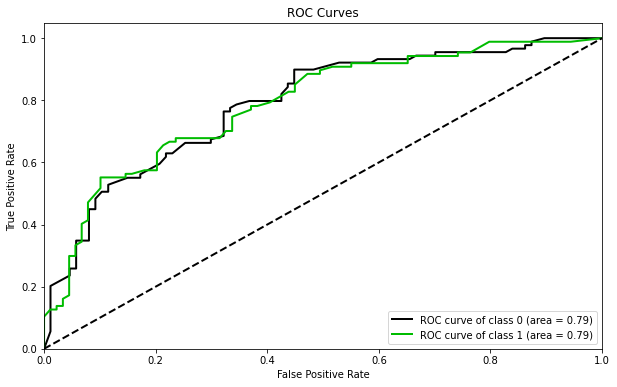

In [33]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(NB_model, params, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

NB = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = NB.predict(Test_X_std)
pred_prob = NB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,3)

---

## 5. Support Vector Machine Classfier:

<<<----------------------------------- Evaluating Support Vector Machine (SVM) ----------------------------------->>>

Accuracy = 84.1%
F1 Score = 84.1%

Confusiton Matrix:
 [[73 16]
 [12 75]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84        89
           1       0.82      0.86      0.84        87

    accuracy                           0.84       176
   macro avg       0.84      0.84      0.84       176
weighted avg       0.84      0.84      0.84       176



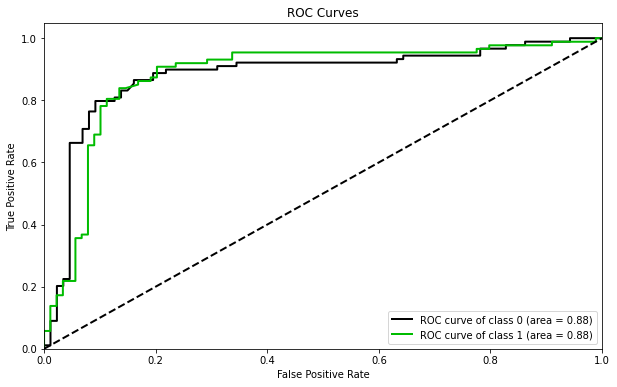

In [34]:
# Building Support Vector Machine Classifier

SVM_model = SVC(probability=True).fit(Train_X_std, Train_Y)

svm_param = {"C": [.01, .1, 1, 5, 10, 100],             
             "gamma": [.01, .1, 1, 5, 10, 100],
             "kernel": ["rbf"],
             "random_state": [1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(SVM_model, svm_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

SVM = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = SVM.predict(Test_X_std)
pred_prob = SVM.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,4)

---

## 6. K-Nearest Neighbours Classfier:

<<<----------------------------------- Evaluating K Nearest Neighbours (KNN) ----------------------------------->>>

Accuracy = 80.10000000000001%
F1 Score = 80.0%

Confusiton Matrix:
 [[65 24]
 [11 76]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.73      0.79        89
           1       0.76      0.87      0.81        87

    accuracy                           0.80       176
   macro avg       0.81      0.80      0.80       176
weighted avg       0.81      0.80      0.80       176



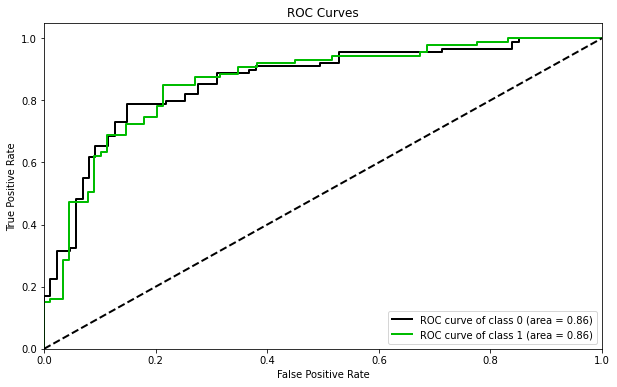

In [35]:
# Building K-Neareset Neighbours Classifier

KNN_model = KNeighborsClassifier()

knn_param = {"n_neighbors": [i for i in range(1,30,5)],
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "leaf_size": [1, 10, 30],
             "p": [1,2]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(KNN_model, knn_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

KNN = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = KNN.predict(Test_X_std)
pred_prob = KNN.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,5)

---

## 7. Gradient Boosting Classfier:

<<<----------------------------------- Evaluating Gradient Boosting (GB) ----------------------------------->>>

Accuracy = 86.4%
F1 Score = 86.4%

Confusiton Matrix:
 [[74 15]
 [ 9 78]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86        89
           1       0.84      0.90      0.87        87

    accuracy                           0.86       176
   macro avg       0.87      0.86      0.86       176
weighted avg       0.87      0.86      0.86       176



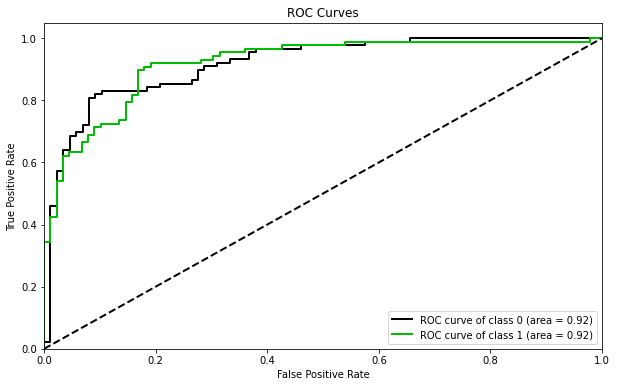

In [36]:
# Building Gradient Boosting Classifier

GB_model = GradientBoostingClassifier().fit(Train_X_std, Train_Y)
param_dist = {
    "n_estimators":[5,20,100,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(GB_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

GB = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = GB.predict(Test_X_std)
pred_prob = GB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,6)

---

## 8. Extreme Gradient Boosting Classfier:

<<<----------------------------------- Evaluating Extreme Gradient Boosting (XGB) ----------------------------------->>>

Accuracy = 84.1%
F1 Score = 84.1%

Confusiton Matrix:
 [[74 15]
 [13 74]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        89
           1       0.83      0.85      0.84        87

    accuracy                           0.84       176
   macro avg       0.84      0.84      0.84       176
weighted avg       0.84      0.84      0.84       176



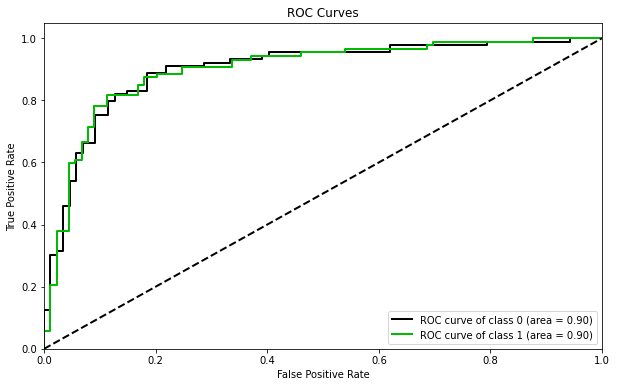

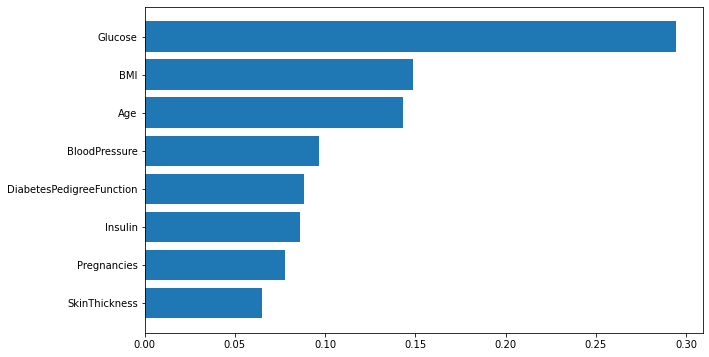

In [37]:
# Building Extreme Gradient Boosting Classifier

XGB_model = XGBClassifier()

param_dist = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

XGB = XGB_model.fit(Train_X_std, Train_Y, eval_metric='logloss')
pred = XGB.predict(Test_X_std)
pred_prob = XGB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,7)

xgbf=pd.DataFrame(XGB.feature_importances_, index=Train_X_std.columns).sort_values(by=0)
plt.barh(xgbf.index,xgbf.values[:,0])
plt.show()

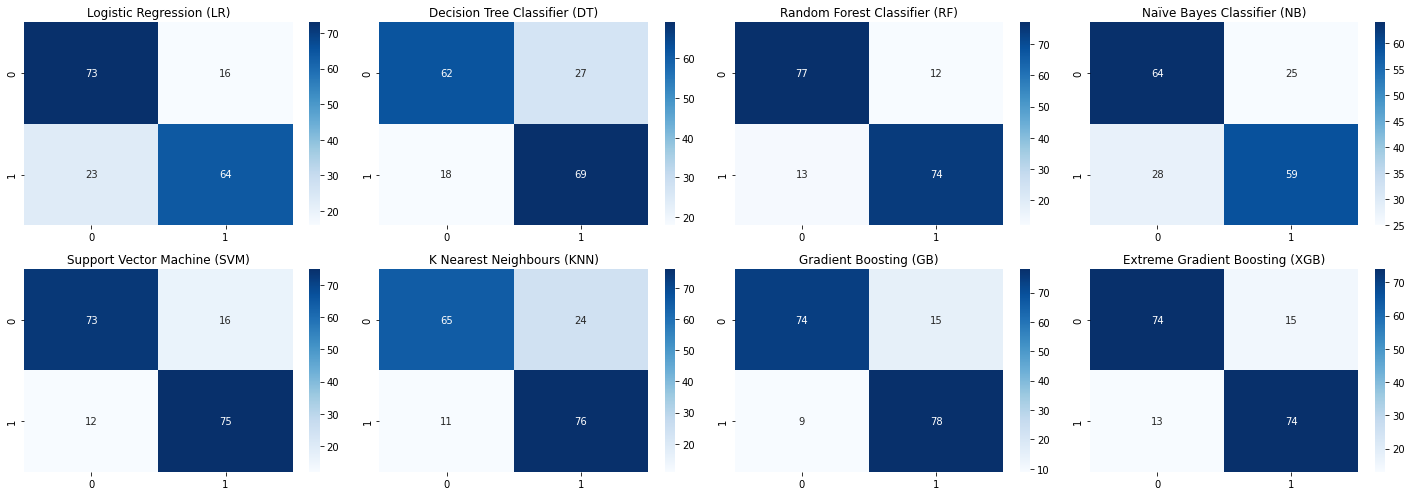

In [38]:
#Plotting Confusion-Matrix of all the predictive Models

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    sns.heatmap(cm, annot=annot, fmt='')
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3.5*math.ceil(len(all_models)*len(labels)/14)])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/3),3,i+1)
        pred = all_models[i].predict(Test_X_std)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, cmap='Blues', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR,DT,RF,NB,SVM,KNN,GB,XGB])

                                    ML Algorithms Comparison                                    


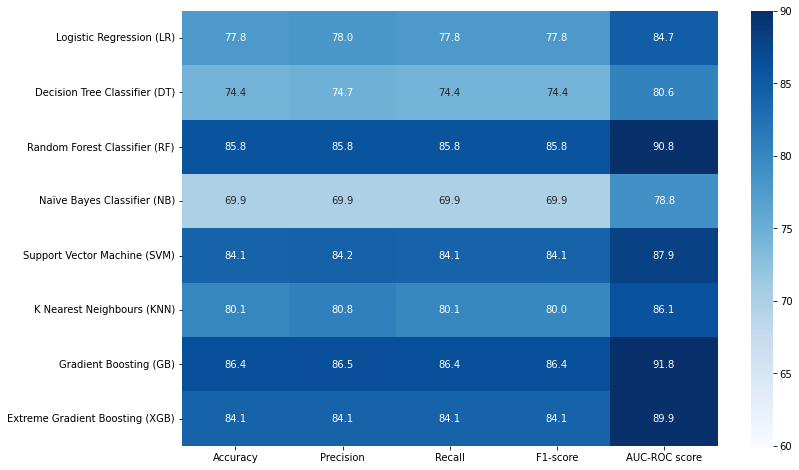

In [39]:
#Comparing all the models Scores

print('\033[1mML Algorithms Comparison'.center(100))
plt.figure(figsize=[12,8])
sns.heatmap(Evaluation_Results, annot=True, vmin=60, vmax=90, cmap='Blues', fmt='.1f')
plt.show()

**Insights:** For the current problem statement, it is more important to focus on the Recall score. We can note from the above heatmap that the SVM, Random Forest & Extreme Gradient Boosting Model Performed well on the current dataset...

---

In [40]:
#<<<---------------------------------------------THE END----------------------------------------------------------------->>>